In [29]:
#导入必要的工具包
# 首先 import 必要的模块
from sklearn.model_selection import GridSearchCV

#竞赛的评价指标为logloss
from sklearn.metrics import log_loss  

import pandas as pd
import numpy as np
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import time

from matplotlib import pyplot
import seaborn as sns
%matplotlib inline

import sys
sys.path.append("..")

from CommonUtils import unzipFile
from CommonUtils import deleteFileByPattern

In [30]:
n_s = np.linspace(0.70, 0.85, num=15)
print("n_s",n_s)

unzipFile("../data/MNIST_train.zip")
unzipFile("../data/MNIST_test.zip")

#读取训练数据和测试数据
train = pd.read_csv('MNIST_train.csv')
test = pd.read_csv('MNIST_test.csv')

y_train = train.label.values
X_train = train.drop("label",axis=1).values
X_test = test.values
X_train



n_s [0.7        0.71071429 0.72142857 0.73214286 0.74285714 0.75357143
 0.76428571 0.775      0.78571429 0.79642857 0.80714286 0.81785714
 0.82857143 0.83928571 0.85      ]


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [31]:
train.describe()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,42000.000000,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,...,42000.000000,42000.000000,42000.000000,42000.00000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0
mean,4.456643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.219286,0.117095,0.059024,0.02019,0.017238,0.002857,0.0,0.0,0.0,0.0
std,2.887730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.312890,4.633819,3.274488,1.75987,1.894498,0.414264,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,253.00000,254.000000,62.000000,0.0,0.0,0.0,0.0


In [32]:
#将像素值[0,255]  --> [0,1]
X_train = X_train / 255.0
X_test = X_test / 255.0

In [33]:
# 原始输入的特征维数和样本数目
print('the shape of train_image: {}'.format(X_train.shape))
print('the shape of test_image: {}'.format(X_test.shape))

the shape of train_image: (42000, 784)
the shape of test_image: (28000, 784)


In [34]:
# 将训练集合拆分成训练集和校验集，在校验集上找到最佳的模型超参数（PCA的维数）
X_train_part, X_val, y_train_part, y_val = train_test_split(X_train,y_train, train_size = 0.8,random_state = 0)
X_train_part

/usr/local/python36/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [35]:
#拆分后的训练集和校验集的样本数目
print(X_train_part.shape)
print(X_val.shape)

(33600, 784)
(8400, 784)


In [36]:
# 一个参数点（PCA维数为n）的模型训练和测试，得到该参数下模型在校验集上的预测性能
def n_component_analysis(n, X_train, y_train, X_val, y_val):
    start = time.time()
    pca = PCA(n_components=n)
    print("PCA begin with n_components: {}".format(n));
    pca.fit(X_train)
    # 在训练集和测试集降维 
    X_train_pca = pca.transform(X_train)
    X_val_pca = pca.transform(X_val)
    print("After PCA shape", X_train_pca.shape)
    # 利用SVC训练
    print('SVC begin')
    clf1 = svm.SVC()
    clf1.fit(X_train_pca, y_train)
    # 返回accuracy
    accuracy = clf1.score(X_val_pca, y_val)
    end = time.time()
    print("accuracy: {}, time elaps:{}".format(accuracy, int(end-start)))
    return accuracy

In [37]:
# 设置超参数（PCA维数）搜索范围
n_s = np.linspace(0.70, 0.85, num=15)
accuracy = []
for n in n_s:
    tmp = n_component_analysis(n, X_train_part, y_train_part, X_val, y_val)
    accuracy.append(tmp)

PCA begin with n_components: 0.7
After PCA shape (33600, 26)
SVC begin
accuracy: 0.9786904761904762, time elaps:27
PCA begin with n_components: 0.7107142857142856
After PCA shape (33600, 28)
SVC begin
accuracy: 0.9791666666666666, time elaps:23
PCA begin with n_components: 0.7214285714285714
After PCA shape (33600, 29)
SVC begin
accuracy: 0.9794047619047619, time elaps:26
PCA begin with n_components: 0.7321428571428571
After PCA shape (33600, 31)
SVC begin
accuracy: 0.9794047619047619, time elaps:24
PCA begin with n_components: 0.7428571428571428
After PCA shape (33600, 32)
SVC begin
accuracy: 0.9801190476190477, time elaps:27
PCA begin with n_components: 0.7535714285714286
After PCA shape (33600, 34)
SVC begin
accuracy: 0.9797619047619047, time elaps:25
PCA begin with n_components: 0.7642857142857142
After PCA shape (33600, 36)
SVC begin
accuracy: 0.9798809523809524, time elaps:29
PCA begin with n_components: 0.7749999999999999
After PCA shape (33600, 38)
SVC begin
accuracy: 0.9791666

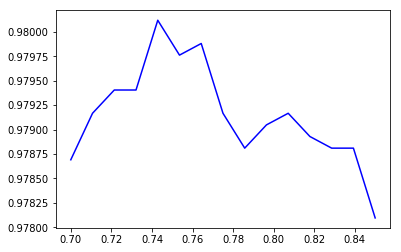

In [38]:
# 绘制不同PCA维数下模型的性能，找到最佳模型／参数（分数最高）
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(n_s, np.array(accuracy), 'b-')

In [39]:
#最佳模型参数
pca = PCA(n_components=0.75)

#根据最佳参数，在全体训练数据上重新训练模型
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=0.75, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [40]:
pca.n_components_

33

In [41]:
pca.explained_variance_ratio_

array([0.09748938, 0.07160266, 0.06145903, 0.05379302, 0.04894262,
       0.04303214, 0.03277051, 0.02892103, 0.02766902, 0.02348871,
       0.02099325, 0.02059001, 0.01702553, 0.01692787, 0.01581126,
       0.0148324 , 0.01319688, 0.01282727, 0.01187976, 0.01152755,
       0.01072191, 0.01015199, 0.00964902, 0.00912846, 0.00887641,
       0.00838766, 0.00811856, 0.00777406, 0.00740635, 0.00686661,
       0.00657982, 0.00638799, 0.00599367])

In [42]:
#根据最佳参数，对全体训练数据降维
X_train_pca = pca.transform(X_train)

#根据最佳参数，对测试数据降维
X_test_pca = pca.transform(X_test)

In [43]:
# 降维后的特征维数
print(X_train_pca.shape)
print(X_test_pca.shape)

(42000, 33)
(28000, 33)


In [44]:
#在降维后的训练数据集上训练SVM分类器
clf = svm.SVC()
clf.fit(X_train_pca, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [45]:
# 用在降维后的全体训练数据集上训练的模型对测试集进行测试
y_predict = clf.predict(X_test_pca)

In [46]:
#生成提交测试结果
import pandas as pd
df = pd.DataFrame(y_predict)
df.columns=['Label']
df.index+=1
df.index.name = 'Imageid'
df.to_csv('SVC_Minist_submission.csv', header=True)

In [48]:
deleteFileByPattern("./MNIST_train*")
deleteFileByPattern("./MNIST_test*")

1